# Cycling
Cycling is a healthy, sustainable and enjoyable activity that can be combined with a daily commute. We therefore adapt a famous MDP model checking example, originally by M. Randour, which went viral due to an appearance on [YouTube](https://youtube.com/watch?v=2iF9PRriA7w). Our adaption focuses on the road cycling aspect of a commute between Maastricht and Aachen.

### The MDP
We model the system dynamics of an agent which we call JPK: In particular, we describe the state of JPK based on its location, the actions reflect the decision to travel towards a next location, and the outcome of this action is arriving at the new location with a high probability, whereas with a lower probability JPK arrives at a different location. We annotate the pairs of cities with travel time, elevation gain, and boredom.
We use a simple model as in [1, Fig. 6].

In [31]:
import stormpy
prism_program = stormpy.parse_prism_program("bikeriding.nm")
prism_program, _ = stormpy.preprocess_symbolic_input(prism_program, [], "ROPTSCHED=true")
options = stormpy.BuilderOptions(True, True)
options.set_build_state_valuations()
options.set_build_choice_labels()
options.set_build_with_choice_origins()
mdp = stormpy.build_sparse_model_with_options(prism_program, options)  
properties = stormpy.parse_properties("R{\"time\"}min=? [F \"Aachen\"]"  )
print(mdp)


-------------------------------------------------------------- 
Model type: 	MDP (sparse)
States: 	32
Transitions: 	53
Choices: 	39
Reward Models:  time, elevgain, boredom
State Labels: 	11 labels
   * deadlock -> 0 item(s)
   * Slenaken -> 1 item(s)
   * Vaals -> 1 item(s)
   * SchinOpGeul -> 1 item(s)
   * Maastricht -> 1 item(s)
   * Valkenburg -> 1 item(s)
   * Epen -> 1 item(s)
   * init -> 1 item(s)
   * Margraten -> 1 item(s)
   * Gulpen -> 1 item(s)
   * Aachen -> 1 item(s)
Choice Labels: 	12 labels
   * select_margraten -> 1 item(s)
   * select_vaals -> 3 item(s)
   * select_valkenburg -> 1 item(s)
   * select_slenaken -> 2 item(s)
   * ride_train -> 1 item(s)
   * select_train -> 1 item(s)
   * select_schin_op_geul -> 1 item(s)
   * ride -> 22 item(s)
   * arrived -> 1 item(s)
   * select_gulpen -> 2 item(s)
   * select_epen -> 2 item(s)
   * select_aachen -> 2 item(s)
-------------------------------------------------------------- 



### Expected Reward
The reward of a path is the sum of the rewards along each transition. 
For any given policy, we can weight the reward along a path by the probability that we take this path. This yields the average or expected reward. The classical perspective on MDPs then allows us to find a policy that minimises the expected travel time. 

In [2]:
result = stormpy.model_checking(mdp, properties[0], extract_scheduler=True)
print(result.at(mdp.initial_states[0]))
scheduler = result.scheduler

75.31672538503513


We can also inspect which policy (which routing) obtains this minimal expected travel time.  

In [32]:
 for state in mdp.states:
        if len(state.labels) > 0:
                choice = scheduler.get_choice(state)
                action_index = choice.get_deterministic_choice()
                action = state.actions[action_index]
                print("In ({}) choose ({})".format(", ".join(state.labels), ", ".join(action.labels)))

In (init, Maastricht) choose (select_margraten)
In (Valkenburg) choose (select_schin_op_geul)
In (Margraten) choose (select_gulpen)
In (Slenaken) choose (select_epen)
In (Aachen) choose (arrived)
In (SchinOpGeul) choose (select_gulpen)
In (Gulpen) choose (select_vaals)
In (Epen) choose (select_vaals)
In (Vaals) choose (select_aachen)


Finally, we can apply the policy to the MDP to obtain a DTMC.



In [4]:
dtmc = mdp.apply_scheduler(scheduler)
print(dtmc)

-------------------------------------------------------------- 
Model type: 	DTMC (sparse)
States: 	22
Transitions: 	29
Reward Models:  boredom, elevgain, time
State Labels: 	11 labels
   * Slenaken -> 0 item(s)
   * deadlock -> 0 item(s)
   * Maastricht -> 1 item(s)
   * Vaals -> 1 item(s)
   * SchinOpGeul -> 1 item(s)
   * Epen -> 1 item(s)
   * Valkenburg -> 1 item(s)
   * Margraten -> 1 item(s)
   * init -> 1 item(s)
   * Gulpen -> 1 item(s)
   * Aachen -> 1 item(s)
Choice Labels: 	12 labels
   * select_slenaken -> 0 item(s)
   * select_margraten -> 1 item(s)
   * select_valkenburg -> 0 item(s)
   * select_vaals -> 2 item(s)
   * ride_train -> 0 item(s)
   * ride -> 14 item(s)
   * arrived -> 1 item(s)
   * select_schin_op_geul -> 1 item(s)
   * select_train -> 0 item(s)
   * select_gulpen -> 2 item(s)
   * select_epen -> 0 item(s)
   * select_aachen -> 1 item(s)
-------------------------------------------------------------- 



### Time-bounded probabilities
Above, we used the expected travel time. However, when giving a lecture, it does not matter whether the expected arrival time is before the lecture, but with what probability one arrives at the lecture on time. Now, we aim to compute the probability of arriving within T minutes using the policy that optimizes the overall expected travel time and the maximal probability that (using any policy) we can achieve.
These probabilities are reward-bounded reachability probabilities. 

In [33]:
tbounds = [56.9, 70, 75, 80, 85, 90, 100, 120]
tboundedproperties_strings = ["Pmax=? [F{\"time\"}<=" + str(t) +" \"Aachen\"]" for t in tbounds]
# Cast into prism program no longer necessary after Stormpy#198 makes it into release
tb_properties = stormpy.parse_properties(";".join(tboundedproperties_strings), prism_program.as_prism_program())

In [34]:
result_mdp = {}
result_dtmc = {}
for tb, tb_prop in zip(tbounds, tb_properties):
        result_mdp[tb] = stormpy.model_checking(mdp, tb_prop, only_initial_states=True).at(mdp.initial_states[0])
        result_dtmc[tb] = stormpy.model_checking(dtmc, tb_prop, only_initial_states=True).at(dtmc.initial_states[0])

In [35]:
print(result_mdp)
print(result_dtmc)
# TODO plot this.

{56.9: 0.0, 70: 0.4309199999999999, 75: 0.7166609999999999, 80: 0.7961999999999998, 85: 0.8725331999999998, 90: 0.9376003199999998, 100: 0.9774146499999999, 120: 0.9984620000000001}
{56.9: 0.0, 70: 0.4309199999999999, 75: 0.4309199999999999, 80: 0.7038359999999998, 85: 0.8725331999999998, 90: 0.8751187199999998, 100: 0.8751187199999998, 120: 0.9719253235199997}


### Trading objectives
Above, we consider a single, clear objective. 
However, we can also ask for a trade-off: Some policies may be marginally better in terms of the probability to arrive on time, but have an expected travel time that is much lower. We can also analyze trade-offs between different reward assignments, e.g., to simultaneously optimize the expected travel time and the expected elevation gain.


In [36]:
multiprops_strings = ["multi(Pmax=? [F{\"time\"}<=90 \"Aachen\"], R{\"time\"}min=? [F \"Aachen\"])", 
                      "multi(R{\"elevgain\"}max=? [ F \"Aachen\"], R{\"time\"}min=? [ F \"Aachen\"])"]
multi_properties = stormpy.parse_properties(";".join(multiprops_strings), prism_program.as_prism_program())
multi_res0 = stormpy.model_checking(mdp, multi_properties[0], only_initial_states=True)
multi_res1 = stormpy.model_checking(mdp, multi_properties[1], only_initial_states=True)

The results are Pareto-curves, that we can plot with some additional code in Stormpy. 

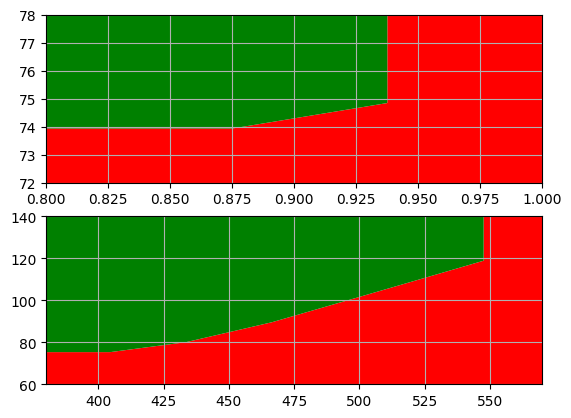

In [38]:
import stormpy.utility
import stormpy.utility.multiobjective_plotting
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2)

lower_left_corner = [0.8,72]
upper_right_corner = [1.0,78]

points = stormpy.utility.multiobjective_plotting.prepare_multiobjective_result_for_plotting(multi_res0, lower_left_corner, upper_right_corner, multi_properties[0].raw_formula)
stormpy.utility.multiobjective_plotting.plot_convex_pareto_curve_demo(ax[0], points[0], points[1], lower_left_corner, upper_right_corner)


lower_left_corner = [380,60]
upper_right_corner = [570,140]

points = stormpy.utility.multiobjective_plotting.prepare_multiobjective_result_for_plotting(multi_res1, lower_left_corner, upper_right_corner, multi_properties[1].raw_formula)
stormpy.utility.multiobjective_plotting.plot_convex_pareto_curve_demo(ax[1], points[0], points[1], lower_left_corner, upper_right_corner)

Indeed, the first Pareto curve below shows how the expected time to travel to Aachen can be traded for the probability to reach Aachen within 90 minutes. It shows that there exist Pareto-optimal policies that reach Aachen in an expected 74 minutes and in 74.8 minutes, respectively, but while the former reaches Aachen on time in only 88% of the cases, the latter reaches Aachen within 90 minutes in 94% of the cases. 

We can also analyze trade-offs between different reward assignments, e.g., to simultaneously optimize the expected travel time and the expected elevation gain, as shown in the second Pareto curve.
Here, we see that when minimizing the expected travel time, JPK can only achieve an expected elevation gain of approximately 405 meters.
To increase this gain, more time needs to be invested. For example, a Pareto optimal policy that achieves an expected elevation gain of 500 meters induces an expected travel time of approximately 100 minutes.



### Efficient and enjoyable, together.
***Multi-reward bounded quantiles*** are a more advanced property to illustrate trade-offs between resource constraints.
Intuitively, such queries fix a threshold on a reward-bounded reachability probability and ask, for which reward-limits the probability threshold is satisfiable.
For the road biking scenario, our goal is to reach Aachen in more than 90\% of the cases while only taking a certain time $t$ and while limiting the boredom during the trip to some value $b$.




In [45]:
quantile_properties = stormpy.parse_properties("quantile(TIMEMAX, BORED, Pmax>0.9 [F{\"time\"}<=TIMEMAX,{\"boredom\"}<=BORED \"Aachen\"])")
quantile_res = stormpy.model_checking(mdp, quantile_properties[0], only_initial_states=True)
print(quantile_res)
# TODO plot code.


4 Pareto optimal points found:
   (         89,          75 )
   (         91,          53 )
   (         97,          10 )
   (        104,           2 )



The green cells in the upper right of [1, Fig 9] illustrate the data as obtained above, for which time and boredom values this goal is achievable by some policy.
We see that JPK can reach Aachen with sufficient probability in 89 minutes. However, this requires to take a rather boring route with a boredom value of 75.
By only taking an additional 2 minutes, the boredom can already be reduced to a value of 53.
Further relaxing the time limit to 97 minutes yields a quite enjoyable road trip with a boredom value of only 10.
